In [1]:
%matplotlib inline

import numpy as np
import os
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.cross_validation
import sklearn.linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

In [2]:
X, y = utils.load_chips()

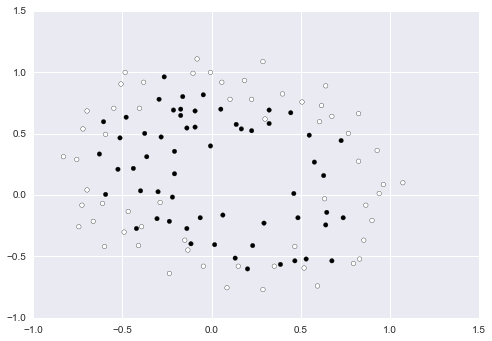

In [3]:
def draw(X, y, result=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xx, yy = np.mgrid[np.min(X[:, 0]):np.max(X[:, 0]):.01, np.min(X[:, 1]):np.max(X[:, 1]):.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    if result is not None:
        probs = predict(grid, result).reshape(xx.shape)
        contour = ax.contourf(xx, yy, probs, 25, cmap="coolwarm",
                              vmin=0, vmax=1)
        ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
        ax_c = fig.colorbar(contour)
    ax.scatter(X[:, 0], X[:, 1], c=y)

draw(X, y)
    

Уже видно, что обычная логистическая линейная регрессия тут не сможет ничего сделать. 

In [4]:
def predict(X, omega):
    return 1.0 / (1 + np.exp(-np.dot((np.hstack((np.ones((X.shape[0], 1)), X))), omega)))
h = predict
def predict_label(X, omega):
    return (predict(X, omega) >= 0.5).astype(int)

In [5]:
def logistic_cost_function(X, Y, regularization_parameter):
    m = len(Y)
    return lambda omega: (
        -1.0 / m * np.sum(Y * np.log(h(X, omega)) + (1 - Y) * (np.log(1 - h(X, omega))))
        + regularization_parameter / (2.0 * m) * np.dot(omega[1:], omega[1:])
    )

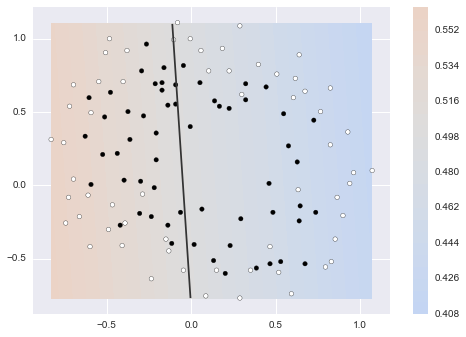

In [6]:
C = 2 ** -3
cost_function = logistic_cost_function(X, y, C)
omega = np.zeros((1, X.shape[1] + 1, ))
result = minimize(cost_function, omega, jac=None).x
draw(X, y, result)

Ожидаемо плохой результат. Идея: перевести датасет в полярные координаты.

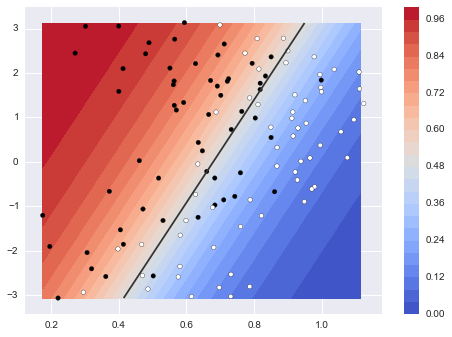

In [7]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

X_polar = np.array([cart2pol(x_, y_) for x_, y_ in X])
C = 2 ** -2
cost_function = logistic_cost_function(X_polar, y, C)
omega = np.zeros((1, X.shape[1] + 1, ))
result = minimize(cost_function, omega, jac=None).x
draw(X_polar, y, result)

С помощью кроссвалидации подберем параметр регуляризации

C = 0.03125
f_measure: min, mean, max: 0.444444444444, 0.758010878011, 0.923076923077
acc: min, mean, max: 0.583333333333, 0.771212121212, 0.916666666667
C = 0.0625
f_measure: min, mean, max: 0.444444444444, 0.765703185703, 1.0
acc: min, mean, max: 0.583333333333, 0.779545454545, 1.0
C = 0.125
f_measure: min, mean, max: 0.444444444444, 0.771157731158, 1.0
acc: min, mean, max: 0.583333333333, 0.787878787879, 1.0
C = 0.25
f_measure: min, mean, max: 0.444444444444, 0.777567987568, 1.0
acc: min, mean, max: 0.583333333333, 0.796212121212, 1.0
C = 0.5
f_measure: min, mean, max: 0.444444444444, 0.760901320901, 0.923076923077
acc: min, mean, max: 0.583333333333, 0.779545454545, 0.916666666667
C = 1.0
f_measure: min, mean, max: 0.6, 0.776456876457, 0.923076923077
acc: min, mean, max: 0.666666666667, 0.787878787879, 0.916666666667
C = 2.0
f_measure: min, mean, max: 0.444444444444, 0.723635253635, 0.923076923077
acc: min, mean, max: 0.583333333333, 0.745454545455, 0.916666666667
C = 4.0
f_measure

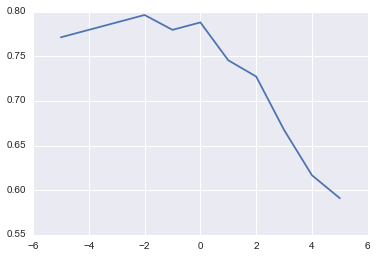

In [129]:
_X = X_polar
points = []
for C in np.logspace(-5, 5, num=11, base=2):
    print("C = {}".format(C))
    r = []
    acc = []
    for train, test in sklearn.cross_validation.StratifiedKFold(y, n_folds=10, shuffle=True, random_state=16):
        X_train, X_test, Y_train, Y_test = _X[train], _X[test], y[train], y[test]
        cost_function = logistic_cost_function(X_train, Y_train, C)
        result = minimize(cost_function, np.zeros((1, X.shape[1] + 1, )), jac=None).x
        predict_label(X_test, result)
        m = sklearn.metrics.precision_recall_fscore_support(Y_test, predict_label(X_test, result), average="binary")
        acc += [sklearn.metrics.accuracy_score(Y_test,  predict_label(X_test, result))] 
        r += [m]
        #draw(X_test, Y_test, result)
    f_measure = np.array([z[2] for z in r])
    acc = np.array(acc)
    print("f_measure: min, mean, max: {}, {}, {}".format(f_measure.min(), f_measure.mean(), f_measure.max()))
    print("acc: min, mean, max: {}, {}, {}".format(acc.min(), acc.mean(), acc.max()))
    points += [acc.mean()]
fig = plt.figure()
ax = fig.gca()
ax.plot(range(-5, 6), points)

C = 0.03125
f_measure: min, mean, max: 0.285714285714, 0.562334332334, 0.8
acc: min, mean, max: 0.416666666667, 0.600757575758, 0.833333333333
C = 0.0625
f_measure: min, mean, max: 0.285714285714, 0.570415140415, 0.8
acc: min, mean, max: 0.454545454545, 0.617424242424, 0.833333333333
C = 0.125
f_measure: min, mean, max: 0.285714285714, 0.569674769675, 0.833333333333
acc: min, mean, max: 0.416666666667, 0.634090909091, 0.833333333333
C = 0.25
f_measure: min, mean, max: 0.444444444444, 0.613154623155, 0.833333333333
acc: min, mean, max: 0.454545454545, 0.668181818182, 0.833333333333
C = 0.5
f_measure: min, mean, max: 0.444444444444, 0.677994227994, 0.833333333333
acc: min, mean, max: 0.583333333333, 0.720454545455, 0.833333333333
C = 1.0
f_measure: min, mean, max: 0.444444444444, 0.706822066822, 0.888888888889
acc: min, mean, max: 0.583333333333, 0.74696969697, 0.909090909091
C = 2.0
f_measure: min, mean, max: 0.444444444444, 0.7391996892, 0.909090909091
acc: min, mean, max: 0.5833333333

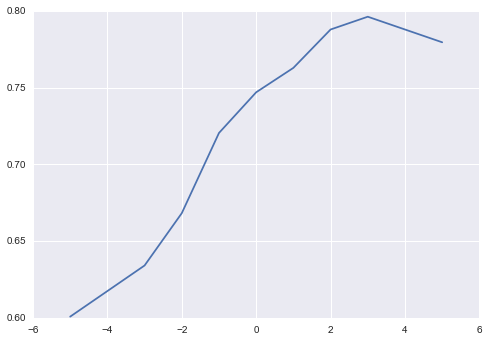

In [13]:
_X = X_polar
points = []
for C in np.logspace(-5, 5, num=11, base=2):
    print("C = {}".format(C))
    r = []
    acc = []
    for train, test in sklearn.cross_validation.StratifiedKFold(y, n_folds=10, shuffle=True, random_state=16):
        X_train, X_test, Y_train, Y_test = _X[train], _X[test], y[train], y[test]
        model = sklearn.linear_model.LogisticRegression("l2", C=C)
        model.fit(X_train, Y_train)
        m = sklearn.metrics.precision_recall_fscore_support(Y_test, model.predict(X_test), average="binary")
        acc += [sklearn.metrics.accuracy_score(Y_test, model.predict(X_test))] 
        r += [m]
        #draw(X_test, Y_test, result)
    f_measure = np.array([z[2] for z in r])
    acc = np.array(acc)
    print("f_measure: min, mean, max: {}, {}, {}".format(f_measure.min(), f_measure.mean(), f_measure.max()))
    print("acc: min, mean, max: {}, {}, {}".format(acc.min(), acc.mean(), acc.max()))
    points += [acc.mean()]
fig = plt.figure()
ax = fig.gca()
ax.plot(range(-5, 6), points)
